Comparison
=========
In this section we are comparing the performance of different tools associated with Single-Cell RNA seq

In [3]:
# Loading the libraries
RPYTHON_PYTHON_VERSION=3.4
library(genefilter)
library(statmod)
require(ggplot2)
library(gplots)
require(DESeq2)
library(scLVM)
library(scde)
library(tools)
library(RColorBrewer)

In [5]:
directory<-"/home/baker/Rna-seq Data Analysis/Tovah_Shaw_single_cell_analysis/htseq_count_output/"

# The sampleFiles try to grep all the files that starts with the name mentioned with grep
sampleFiles<-grep("htseq_count",list.files(directory), value=TRUE)
# Sample condition
sampleCondition<-c(paste0('Cell_',1:96))
sampleTable<-data.frame(sampleName=file_path_sans_ext(sampleFiles), fileName=sampleFiles, condition=sampleCondition)

In [6]:
head(sampleTable)

sampleName            fileName condition
1 htseq_count_C01 htseq_count_C01.txt    Cell_1
2 htseq_count_C02 htseq_count_C02.txt    Cell_2
3 htseq_count_C03 htseq_count_C03.txt    Cell_3
4 htseq_count_C04 htseq_count_C04.txt    Cell_4
5 htseq_count_C05 htseq_count_C05.txt    Cell_5
6 htseq_count_C06 htseq_count_C06.txt    Cell_6

In [7]:
# Generating the model with non-normalized data
ddsHTSeq<-DESeqDataSetFromHTSeqCount(sampleTable=sampleTable,directory=directory, design = ~condition)

In [8]:
# Extracting the Raw counts and saving the data into a csv file
NonNormCounts<-as.data.frame(counts(ddsHTSeq,normalized=FALSE))
write.csv(NonNormCounts,"Tovah_single_cell_RNA_seq_RAW_Count.csv")


In [123]:
median.default(data.matrix(NonNormCounts[4,],rownames.force = NA))

[1] 0

In [9]:
#Getting the size factor
sizeFactor <- estimateSizeFactors(ddsHTSeq)
write.csv(sizeFactors(sizeFactor), "Tovah_single_cell_RNA_seq_sizeFactor.csv")

In [8]:
# Running the actual DESeq program in order to get Normalized Data
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)

# Extracting the Normalized counts and saving the data into a csv file
#NormCounts<-as.data.frame(counts(ddsHTSeq,normalized=TRUE))
#write.csv(NormCounts,"Tovah_single_cell_RNA_seq_Normalized_Count.csv")

estimating size factors
estimating dispersions
Warning message:
In .local(object, ...): same number of samples and coefficients to fit,
  estimating dispersion by treating samples as replicates.
  read the ?DESeq section on 'Experiments without replicates'gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [9]:
vsd <- varianceStabilizingTransformation(ddsHTSeq, blind=TRUE)
#rlogVal <- rlog(ddsHTSeq, blind=TRUE)

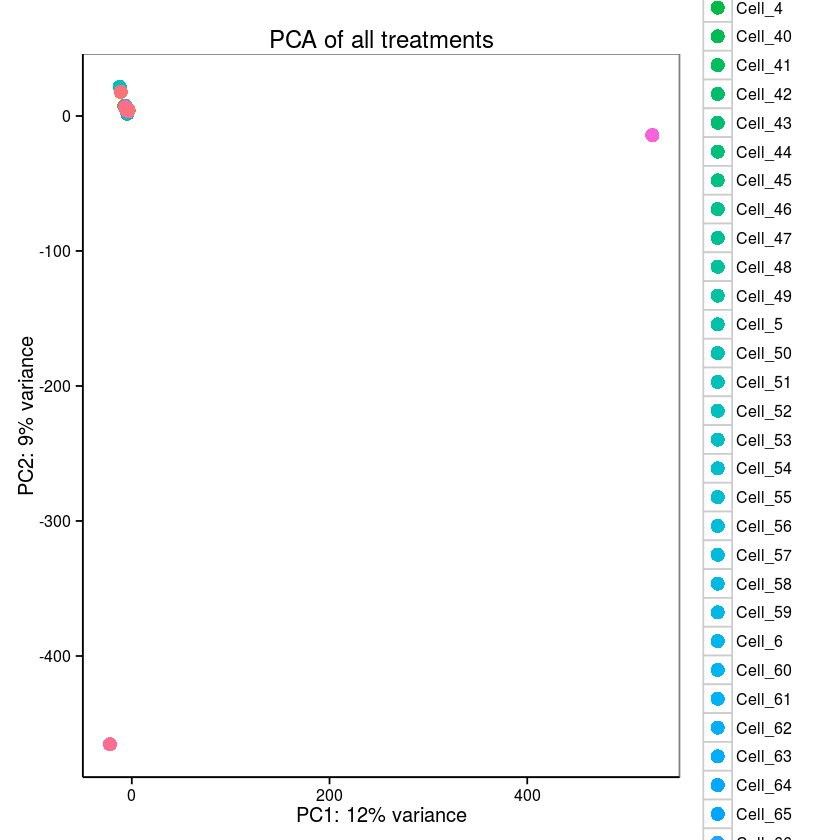

In [218]:
#=============PCA plot within DESeq is used ====================
#pdf("Component1_vs_component2.pdf") # Used this function to save the file in pdf format

# plotPCA is a function within DESeq2 to caclulate the pca
PCAdata<-plotPCA(rlogVal, intgroup=c("condition"),returnData=TRUE)

# Rounding the pca variance into percentage values
percentVar <- round(100 * attr(PCAdata, "percentVar"))

# Creating the plot now
myplot=qplot(PC1, PC2, color=condition, data=PCAdata,size=I(4)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ggtitle("PCA of all treatments") +
scale_size_manual(values=c(3,6))+
  ylab(paste0("PC2: ",percentVar[2],"% variance"))
myplot + theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))
#dev.off();

In [ ]:
# scale function transforms columns by default hence the need for transposition.
z <- t(assay(vsd)) 

quantile(z)

#         0%        25%        50%        75%       100% 
# -2.1843994 -0.6646909 -0.2239677  0.3440102  2.2640027 

# set custom distance and clustering functions
hclustfunc <- function(x) hclust(x, method="complete")
distfunc <- function(x) dist(x,method="maximum")

# obtain the clusters
fit <- hclustfunc(distfunc(z))
clusters <- cutree(fit, 5) 

# require(gplots)
pdf(file='heatmap.pdf', height=50, width=50)
heatmap.2(z, trace='none', dendrogram='row', Colv=F, scale='none', 
             hclust=hclustfunc, distfun=distfunc, col=greenred(256), symbreak=T,
             margins=c(3,3), keysize=0.5, 
             lwid=c(1,0.05,1), lhei=c(0.03,1), lmat=rbind(c(5,0,4),c(3,1,2)),
             RowSideColors=as.character(clusters))
dev.off()

In [1]:
# Calculating Dendogram
distsRL <- dist(t(assay(vsd)))

mat <- as.matrix(distsRL)
rownames(mat) <- colnames(mat) <- with(colData(ddsHTSeq),paste(sampleCondition))

ERROR: Error in t(assay(vsd)): could not find function "assay"


ERROR: Error in as.matrix(distsRL): object 'distsRL' not found


ERROR: Error in with(colData(ddsHTSeq), paste(sampleCondition)): could not find function "colData"


In [214]:
write.csv(data.matrix(distsRL), 'Tovah_distance_matrix_VSD_transformation.csv')

png 
  3

pdf 
  2

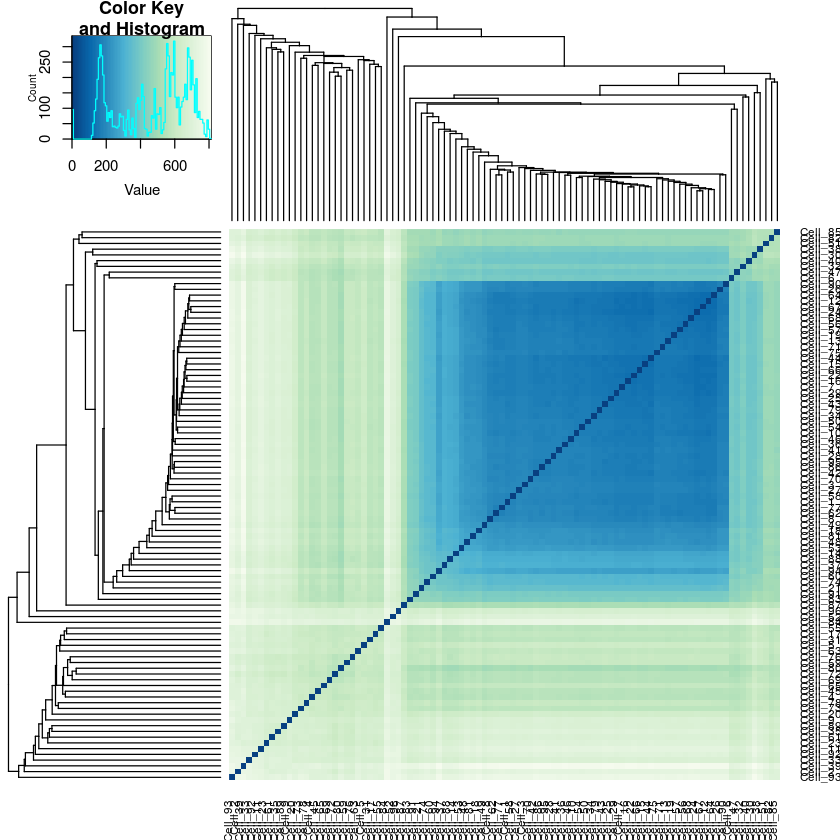

In [215]:
hmcol <- colorRampPalette(brewer.pal(9, "GnBu"))(100)
hc <- hclust(distsRL)
heatmap.2(mat, Rowv=as.dendrogram(hc),
symm=TRUE, trace="none",
col = rev(hmcol), margin=c(3, 3),
         RowSideColors=as.character(clusters))
          
dev.copy(png,"deseq2_heatmaps_samplebysample.png")
dev.off()

In [216]:
(hc$order)

[1] 93  2 39 33 92 11 23 61 35 89  9 20 73 78  4 45 65 69 72 80 59 76 63  5 31
[26] 17 55 84 52 96 87 83 91 21 74 60 94 37 88 14 53 48 81 18 49  8 62 77  1 58
[51] 27  3 70 42 86 95 28 41 36 46 10 54 50 34 79 43 25 29  7 16 22 66 15 44 75
[76] 71 13 19 57 56 68 24 67 12 64 26 90  6 47 32 40 30 38 51 82 85

png 
  3

pdf 
  2

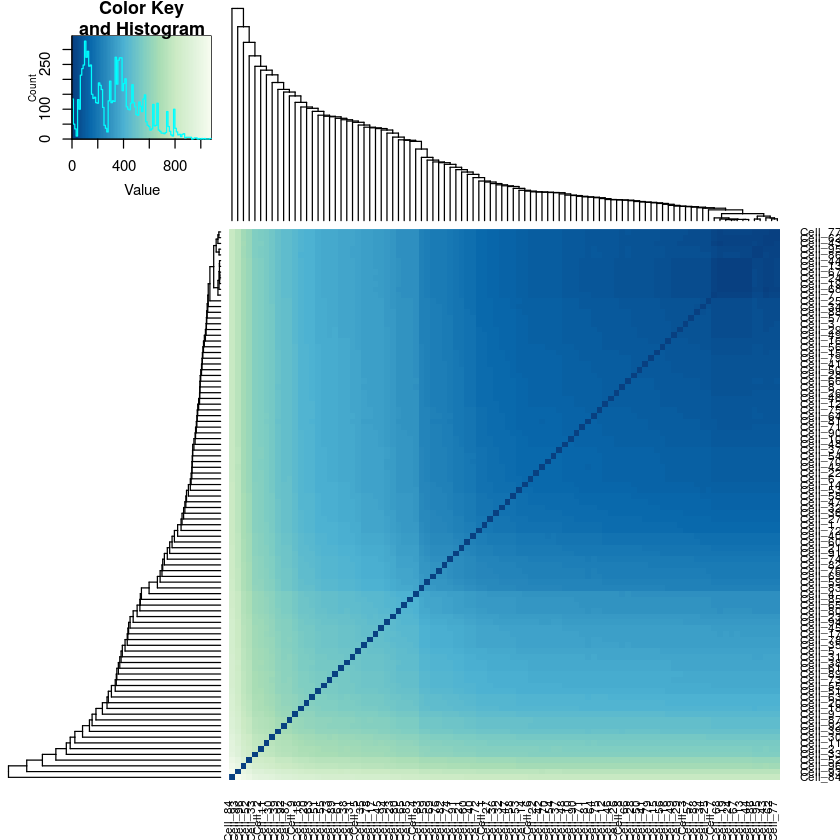

In [217]:
# Calculating Dendogram rlogVal
distsRL <- dist(t(assay(rlogVal)))

mat <- as.matrix(distsRL)
rownames(mat) <- colnames(mat) <- with(colData(ddsHTSeq),paste(sampleCondition))

hmcol <- colorRampPalette(brewer.pal(9, "GnBu"))(100)
hc <- hclust(distsRL)
heatmap.2(mat, Rowv=as.dendrogram(hc),
symm=TRUE, trace="none",
col = rev(hmcol), margin=c(3, 3))
          
dev.copy(png,"deseq2_heatmaps_samplebysample_rlog.png")
dev.off()

In [222]:
colDataNames

ERROR: Error in eval(expr, envir, enclos): object 'colDataNames' not found


In [223]:
# Generating the model with non-normalized data
ddsHTSeq<-DESeqDataSetFromHTSeqCount(sampleTable=sampleTable,directory=directory, design = ~condition)


htseq_count_C01 htseq_count_C02 htseq_count_C03
ENSMUSG00000000001.4                0               0        9.013719
ENSMUSG00000000003.12               0               0        0.000000
ENSMUSG00000000028.11               0               0        0.000000
                      htseq_count_C04 htseq_count_C05 htseq_count_C06
ENSMUSG00000000001.4                0        176.4312               0
ENSMUSG00000000003.12               0          0.0000               0
ENSMUSG00000000028.11               0          0.0000               0
                      htseq_count_C07 htseq_count_C08 htseq_count_C09
ENSMUSG00000000001.4                0               0               0
ENSMUSG00000000003.12               0               0               0
ENSMUSG00000000028.11               0               0               0
                      htseq_count_C10 htseq_count_C11 htseq_count_C12
ENSMUSG00000000001.4                0        570.4756               0
ENSMUSG00000000003.12               0          0.0000               0
ENSMUSG00000000028.11               0          0.0000               0
                      htseq_count_C13 htseq_count_C14 htseq_count_C15
ENSMUSG00000000001.4                0               0               0
ENSMUSG00000000003.12               0               0               0
ENSMUSG00000000028.11               0               0               0
                      htseq_count_C16 htseq_count_C17 htseq_count_C18
ENSMUSG00000000001.4                0        64.13552               0
ENSMUSG00000000003.12               0         0.00000               0
ENSMUSG00000000028.11               0         0.00000               0
                      htseq_count_C19 htseq_count_C20 htseq_count_C21
ENSMUSG00000000001.4                0               0               0
ENSMUSG00000000003.12               0               0               0
ENSMUSG00000000028.11               0               0               0
                      htseq_count_C22 htseq_count_C23 htseq_count_C24
ENSMUSG00000000001.4                0               0               0
ENSMUSG00000000003.12               0               0               0
ENSMUSG00000000028.11               0               0               0
                      htseq_count_C25 htseq_count_C26 htseq_count_C27
ENSMUSG00000000001.4                0               0               0
ENSMUSG00000000003.12               0               0               0
ENSMUSG00000000028.11               0               0               0
                      htseq_count_C28 htseq_count_C29 htseq_count_C30
ENSMUSG00000000001.4                0               0               0
ENSMUSG00000000003.12               0               0               0
ENSMUSG00000000028.11               0               0               0
                      htseq_count_C31 htseq_count_C32 htseq_count_C33
ENSMUSG00000000001.4         78.61455               0               0
ENSMUSG00000000003.12         0.00000               0               0
ENSMUSG00000000028.11         0.00000               0               0
                      htseq_count_C34 htseq_count_C35 htseq_count_C36
ENSMUSG00000000001.4                0        671.0002               0
ENSMUSG00000000003.12               0          0.0000               0
ENSMUSG00000000028.11               0          0.0000               0
                      htseq_count_C37 htseq_count_C38 htseq_count_C39
ENSMUSG00000000001.4                0               0       574.56961
ENSMUSG00000000003.12               0               0         0.00000
ENSMUSG00000000028.11               0               0        14.22202
                      htseq_count_C40 htseq_count_C41 htseq_count_C42
ENSMUSG00000000001.4                0         20.0441               0
ENSMUSG00000000003.12               0          0.0000               0
ENSMUSG00000000028.11               0          0.0000               0
                      htseq_count_C43 htseq_count_C44 htseq_count_C45
ENSMUSG00000000001.4            

In [227]:
write.csv(fpm(ddsHTSeq, robust=FALSE), 'Tovah_Shaw_DESEq2_fpm.csv')

Single-Cell Differential Expression (SCDE)
--------------------------------------------------
We First run the SCDE with the data. As a first step we fit the error models on which all the subsequent calculation for SCDE will depend. This fitting process depends on a set of genes that are identified in cross-cell comparisons. As we have two types of cell, __ESC__ and __MEF__ we fitted the model inpdependently for this two types of cell. That is why we grouped them and used the command `groups=sg`. If the `groups` argument is ommitted then the error model will be fitted with all the data as a common set. 

In [ ]:
cd<-read.csv("Tovah_single_cell_RNA_seq_RAW_Count.csv",check.names=FALSE,row.names=1)
# omit genes that are never detected
#cd <- cd[rowSums(cd)>0,];
# omit cells with very poor coverage
#cd <- cd[,colSums(cd)>1e4]; 

__Building the error model:__

In [ ]:
# number of local process cores to use in processing
n.cores <- 4;
# calculate models
o.ifm <- scde.error.models(counts=cd,n.cores=n.cores,threshold.segmentation=T,save.crossfit.plots=TRUE,save.model.plots=T,verbose=1);

cross-fitting cells.


ERROR: Error in Cairo(width, height, type = "png", file = filename, pointsize = pointsize, : Failed to create Cairo backend!


The `o.ifm` is a dataframe with error model coefficients for each cell (rows).

In [128]:
head(o.ifm)

conc.b    conc.a    fail.r   corr.b    corr.a corr.theta
htseq_count_C01 -7.604317 0.8527689 -2.302585 3.810529 0.2949084  0.4376910
htseq_count_C02 -2.094262 0.4814882 -2.302585 3.382539 0.4680379  0.6227843
htseq_count_C03 -7.659622 0.8949115 -2.302585 5.658208 0.1514748  0.3464416
htseq_count_C04 -3.266659 0.5835924 -2.302585 3.644438 0.4063953  0.4874486
htseq_count_C05 -2.588085 0.5668948 -2.302585 3.733481 0.4968407  0.5830091
htseq_count_C06 -3.127538 0.5590005 -2.302585 2.776297 0.4162938  0.5583002

SCDE uses a finite mixture model where `conc.*` refer to concomitant fit (parameters for the mixture model). The `corr.a` is the slope and `corr.b` is the intersect of the correlated component fit (again for the mixture model), `corr.theta` is the NB over-dispersion, and `fail.r` is the background Poisson rate (fixed). 

__Poor__ cells may result in abnormal fits, which most commonly shows _negtive_ `corr.a`, and should be removed:

In [129]:
# filter out cells that don't show positive correlation with
# the expected expression magnitudes (very poor fits)
valid.cells <- o.ifm$corr.a >0;
table(valid.cells)

valid.cells
TRUE 
  88 

Finally, we now define the expression magnitude prior for the genes. Its main function, is to define a grid of expression magnitude values on which the numerical calculations will be carried out [\[scde tutorial\]](http://pklab.med.harvard.edu/scde/Tutorials/). `scde.expression.prior` uses existing count data to determine a prior distribution of genes in the dataset.


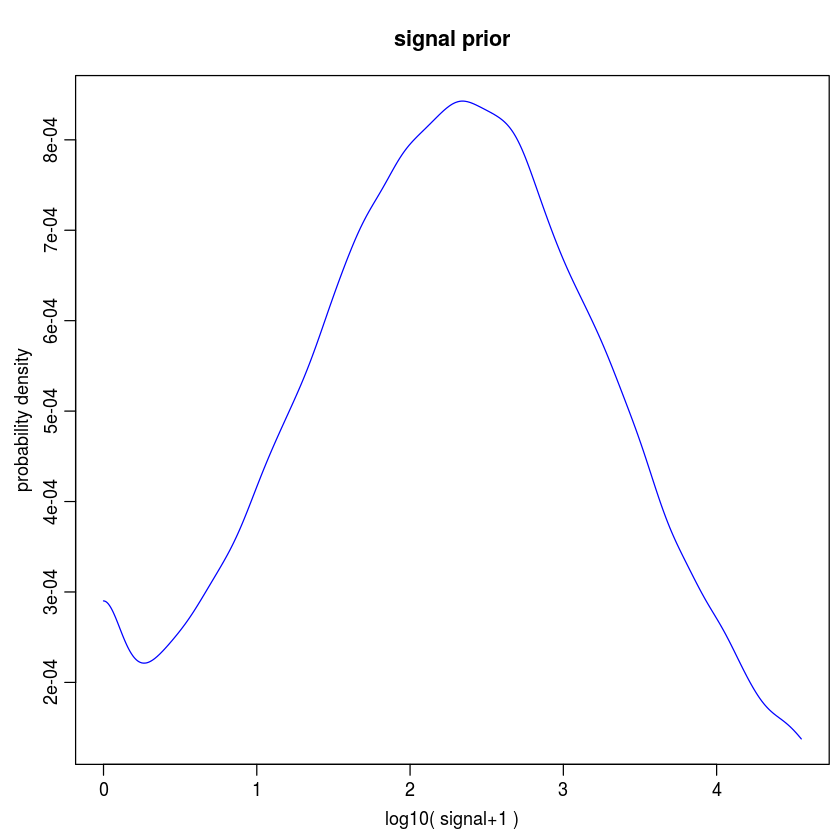

In [136]:
# estimate gene expression prior
o.prior <- scde.expression.prior(models=o.ifm,counts=cd,length.out=2000,show.plot=T)

In [137]:
head(o.prior)

x            y        lp grid.weight
1 0.000000000 0.0002901201 -8.145216 0.002623966
2 0.002276163 0.0002901025 -8.145276 0.005268605
3 0.004552325 0.0002900498 -8.145458 0.005296291
4 0.006828488 0.0002899620 -8.145761 0.005324122
5 0.009104651 0.0002898392 -8.146184 0.005352099
6 0.011380813 0.0002896816 -8.146728 0.005380223

As we used the parameter `length.out=400` the function generates a grid of 400 points. The maximum expression magnitude is determined by the default 0.999 quantile. 

In [146]:
desc(o.ifm)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘desc’ for signature ‘"data.frame"’


In [228]:
scdeExpectExpression <- scde.expression.magnitude(models=o.ifm,counts=cd)
write.csv(scdeExpectExpression, 'Tovah_Shaw_SCDE_FPM.csv')

Testing for differential expression using scde
---------------------------------------------------------
Firt we define the factors that specifies which two groups of cells we are going to compare first. These factors elements are determined based on the row of the `o.ifm` matrix. This matrix can contain `NA` values. Here we key off the ES and MEF names

In [142]:
# define two groups of cells
# groups <- factor(gsub("(MEF|ESC).*","\\1",rownames(o.ifm)),levels=c("ESC","MEF")); 
# names(groups) <- row.names(o.ifm);
# run differential expression tests on all genes.
groups <- factor(c(paste0('Cell_',1:96)), levels=c(paste0('Cell_',1:96)))
ediff <- scde.expression.difference(o.ifm,cd,o.prior,groups=groups,n.randomizations=100,n.cores=n.cores,verbose=1)

ERROR: Error in scde.expression.difference(o.ifm, cd, o.prior, groups = groups, : ERROR: wrong number of levels in the grouping factor (Cell_1 Cell_2 Cell_3 Cell_4 Cell_5 Cell_6 Cell_7 Cell_8 Cell_9 Cell_10 Cell_11 Cell_12 Cell_13 Cell_14 Cell_15 Cell_16 Cell_17 Cell_18 Cell_19 Cell_20 Cell_21 Cell_22 Cell_23 Cell_24 Cell_25 Cell_26 Cell_27 Cell_28 Cell_29 Cell_30 Cell_31 Cell_32 Cell_33 Cell_34 Cell_35 Cell_36 Cell_37 Cell_38 Cell_39 Cell_40 Cell_41 Cell_42 Cell_43 Cell_44 Cell_45 Cell_46 Cell_47 Cell_48 Cell_49 Cell_50 Cell_51 Cell_52 Cell_53 Cell_54 Cell_55 Cell_56 Cell_57 Cell_58 Cell_59 Cell_60 Cell_61 Cell_62 Cell_63 Cell_64 Cell_65 Cell_66 Cell_67 Cell_68 Cell_69 Cell_70 Cell_71 Cell_72 Cell_73 Cell_74 Cell_75 Cell_76 Cell_77 Cell_78 Cell_79 Cell_80 Cell_81 Cell_82 Cell_83 Cell_84 Cell_85 Cell_86 Cell_87 Cell_88 Cell_89 Cell_90 Cell_91 Cell_92 Cell_93 Cell_94 Cell_95 Cell_96), but must be two.


In [243]:
ediff

lb         mle          ub          ce
Rpl4                   -0.03939105  0.00000000  0.51208371  0.00000000
Thbs1                  -6.46013298 -4.88449079 -3.11189332 -3.11189332
Fn1                    -6.02683137 -4.52997129 -2.71798278 -2.71798278
Gm10076                -0.55147477  0.00000000  0.51208371  0.00000000
Rps5                   -0.11817316  0.31512844  1.41807797  0.00000000
Rpl19                  -0.35451949  0.00000000  1.06355848  0.00000000
Rpl23                  -0.27573738  0.07878211  1.18173164  0.00000000
Rps4x                   0.00000000  0.94538531  2.08772590  0.00000000
S100a6                 -6.65708825 -5.00266395 -2.99372016 -2.99372016
Actb                   -4.33301602 -2.67859172 -0.86660320 -0.86660320
Rpl37a                 -1.10294953  0.11817316  1.29990481  0.00000000
Eef1a1                 -0.94538531  0.31512844  1.57564219  0.00000000
Tmsb4x                 -5.31779239 -3.66336809 -1.77259746 -1.77259746
Rps19                   0.19695527  1.57564219  2.63920067  0.19695527
Tpm1                   -6.61769720 -4.88449079 -2.83615594 -2.83615594
Rps9                   -0.11817316  1.29990481  2.40285434  0.00000000
Rps20                   0.11817316  1.49686008  2.52102750  0.11817316
Rps29                  -0.43330160  1.02416742  2.20589907  0.00000000
Rpl10                   0.11817316  1.65442430  2.83615594  0.11817316
Rpl10a                  0.55147477  2.04833485  3.23006649  0.55147477
Rpl38                  -1.06355848  0.63025688  2.04833485  0.00000000
Actg1                  -3.50580387 -1.61503324  0.31512844  0.00000000
Rpl13a                 -0.51208371  1.14234059  2.44224539  0.00000000
Rpl6                    0.39391055  1.96955274  3.23006649  0.39391055
Rps26                  -0.35451949  1.29990481  2.59980961  0.00000000
Rps14                  -0.39391055  1.26051375  2.56041856  0.00000000
Cald1                  -7.95699306 -6.06622243 -4.09666969 -4.09666969
Rps23                   0.07878211  1.69381535  2.87554700  0.07878211
Gm10925                -0.63025688  1.14234059  2.79676489  0.00000000
Sparc                  -6.77526141 -4.96327290 -3.07250227 -3.07250227
Col1a2                 -7.16917196 -5.23901028 -3.15128438 -3.15128438
Eef1g                  -3.23006649 -1.33929586  0.55147477  0.00000000
Rpl32                  -0.03939105  1.65442430  3.07250227  0.00000000
Lox                    -7.28734513 -5.39657450 -3.50580387 -3.50580387
Rpl35a                 -0.11817316  1.57564219  2.95432911  0.00000000
Akap5                  -6.18439559 -4.25423391 -2.28468117 -2.28468117
Rpl36a                 -0.27573738  1.45746903  2.95432911  0.00000000
Rps27a                 -0.03939105  1.65442430  3.07250227  0.00000000
Rps12                   0.07878211  1.81198852  3.19067543  0.07878211
Rps21                  -1.18173164  0.55147477  2.20589907  0.00000000
Rplp0                   0.39391055  2.04833485  3.38763071  0.39391055
Rps3                    0.23634633  1.96955274  3.34823965  0.23634633
Rps16                   0.11817316  1.81198852  3.23006649  0.11817316
Rps27                  -0.03939105  1.65442430  3.15128438  0.00000000
Rpl39                  -0.19695527  1.45746903  3.03311121  0.00000000
Vim                    -5.98744032 -4.01788758 -1.96955274 -1.96955274
Rpl27a                  0.31512844  2.04833485  3.46641282  0.31512844
Rpl24                  -1.10294953  0.59086582  2.28468117  0.00000000
Rpl26                  -0.07878211  1.61503324  3.15128438  0.00000000
Col1a1                 -6.53891509 -4.60875340 -2.71798278 -2.71798278
Eef1b2                 -0.03939105  1.77259746  3.26945754  0.00000000
Tmsb10                 -3.58458598 -1.77259746  0.03939105  0.00000000
Rpl18a                 -0.15756422  1.57564219  3.19067543  0.00000000
Cd81                   -5.94804926 -4.09666969 -2.20589907 -2.20589907
Rpl23a                 -0.07878211  1.73320641  3.30884860  0.00000000
Timp2                  -6.69647930 -4.80570868 -2.914938

In [244]:
# top upregulated genes (tail would show top downregulated ones)
head(ediff[order(ediff$Z,decreasing=T),])

lb      mle        ub       ce        Z       cZ
Dppa5a        8.075166 9.965937 11.502188 8.075166 7.160813 5.993969
Tdh           5.790485 7.996384 10.359847 5.790485 7.160704 5.993969
Pou5f1        5.475357 7.366127  9.375071 5.475357 7.160698 5.993969
Ift46         5.475357 7.444909  9.296289 5.475357 7.160314 5.993969
Gm13242       5.554139 7.602474  9.729591 5.554139 7.154507 5.993969
4930509G22Rik 5.317792 7.523691  9.926546 5.317792 7.146355 5.993969

In [245]:
# write out a table with all the results, showing most significantly different genes (in both directions) on top
write.table(ediff[order(abs(ediff$Z),decreasing=T),],file="results.txt",row.names=T,col.names=T,sep="\t",quote=F)

lb      mle       ub       ce        Z       cZ
Tdh 5.790485 7.996384 10.32046 5.790485 7.152656 7.152656

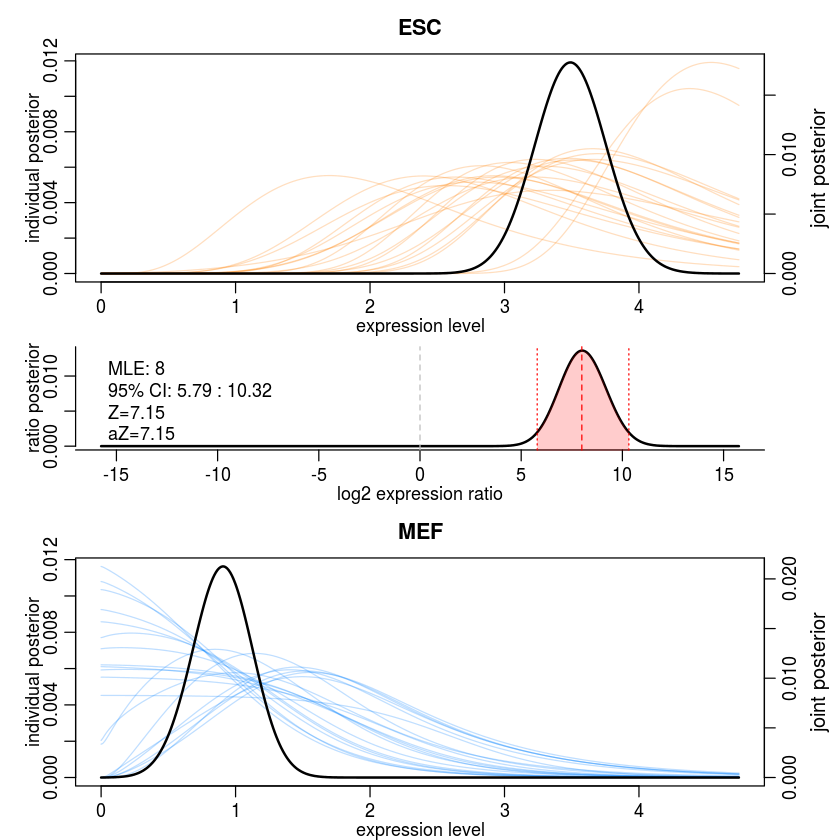

In [246]:
scde.test.gene.expression.difference("Tdh",models=o.ifm,counts=cd,prior=o.prior)

In [239]:
o.prior

x            y        lp  grid.weight
1   0.00000000 0.0003842485 -7.864221 1.374551e-02
2   0.01185789 0.0003851745 -7.861814 2.806044e-02
3   0.02371578 0.0003879262 -7.854695 2.883715e-02
4   0.03557367 0.0003924711 -7.843048 2.963536e-02
5   0.04743156 0.0003987859 -7.827086 3.045567e-02
6   0.05928945 0.0004065220 -7.807873 3.129868e-02
7   0.07114733 0.0004154896 -7.786053 3.216503e-02
8   0.08300522 0.0004254907 -7.762268 3.305535e-02
9   0.09486311 0.0004363321 -7.737107 3.397032e-02
10  0.10672100 0.0004478800 -7.710985 3.491062e-02
11  0.11857889 0.0004599453 -7.684403 3.587694e-02
12  0.13043678 0.0004723943 -7.657697 3.687002e-02
13  0.14229467 0.0004851630 -7.631026 3.789058e-02
14  0.15415256 0.0004982260 -7.604457 3.893939e-02
15  0.16601045 0.0005115958 -7.577976 4.001723e-02
16  0.17786834 0.0005253592 -7.551428 4.112490e-02
17  0.18972622 0.0005395414 -7.524791 4.226324e-02
18  0.20158411 0.0005542147 -7.497958 4.343308e-02
19  0.21344200 0.0005694509 -7.470838 4.463531e-02
20  0.22529989 0.0005853140 -7.443362 4.587081e-02
21  0.23715778 0.0006018991 -7.415421 4.714052e-02
22  0.24901567 0.0006192452 -7.387009 4.844536e-02
23  0.26087356 0.0006373138 -7.358248 4.978633e-02
24  0.27273145 0.0006560969 -7.329202 5.116441e-02
25  0.28458934 0.0006755740 -7.299948 5.258064e-02
26  0.29644723 0.0006957164 -7.270569 5.403607e-02
27  0.30830511 0.0007165652 -7.241041 5.553179e-02
28  0.32016300 0.0007380237 -7.211535 5.706891e-02
29  0.33202089 0.0007600676 -7.182103 5.864857e-02
30  0.34387878 0.0007826932 -7.152770 6.027196e-02
31  0.35573667 0.0008059120 -7.123536 6.194029e-02
32  0.36759456 0.0008297790 -7.094351 6.365479e-02
33  0.37945245 0.0008543738 -7.065142 6.541676e-02
34  0.39131034 0.0008796960 -7.035934 6.722749e-02
35  0.40316823 0.0009058080 -7.006683 6.908834e-02
36  0.41502612 0.0009327741 -6.977348 7.100071e-02
37  0.42688401 0.0009606565 -6.947894 7.296600e-02
38  0.43874189 0.0009896105 -6.918199 7.498570e-02
39  0.45059978 0.0010196187 -6.888327 7.706130e-02
40  0.46245767 0.0010506716 -6.858326 7.919436e-02
41  0.47431556 0.0010827738 -6.828229 8.138645e-02
42  0.48617345 0.0011159118 -6.798083 8.363923e-02
43  0.49803134 0.0011500755 -6.767928 8.595436e-02
44  0.50988923 0.0011852936 -6.737765 8.833357e-02
45  0.52174712 0.0012213972 -6.707760 9.077864e-02
46  0.53360501 0.0012583226 -6.677976 9.329139e-02
47  0.54546290 0.0012960086 -6.648466 9.587369e-02
48  0.55732078 0.0013344017 -6.619272 9.852747e-02
49  0.56917867 0.0013735122 -6.590384 1.012547e-01
50  0.58103656 0.0014133015 -6.561827 1.040574e-01
51  0.59289445 0.0014537377 -6.533617 1.069377e-01
52  0.60475234 0.0014948443 -6.505733 1.098978e-01
53  0.61661023 0.0015366622 -6.478143 1.129397e-01
54  0.62846812 0.0015792468 -6.450807 1.160659e-01
55  0.64032601 0.0016227727 -6.423619 1.192786e-01
56  0.65218390 0.0016671986 -6.396611 1.225802e-01
57  0.66404179 0.0017125753 -6.369757 1.259733e-01
58  0.67589968 0.0017589389 -6.343045 1.294602e-01
59  0.68775756 0.0018063064 -6.316471 1.330436e-01
60  0.69961545 0.0018547297 -6.290016 1.367263e-01
61  0.71147334 0.0019041911 -6.263698 1.405109e-01
62  0.72333123 0.0019545660 -6.237587 1.444002e-01
63  0.73518912 0.0020057907 -6.211717 1.483972e-01
64  0.74704701 0.0020577943 -6.186121 1.525048e-01
65  0.75890490 0.0021105047 -6.160828 1.567261e-01
66  0.77076279 0.0021639224 -6.135833 1.610643e-01
67  0.78262068 0.0022179282 -6.111182 1.655226e-01
68  0.79447857 0.0022724771 -6.086885 1.701042e-01
69  0.80633645 0.0023275535 -6.062938 1.748127e-01
70  0.81819434 0.0023831596 -6.039328 1.796515e-01
71  0.83005223 0.0024393346 -6.016030 1.846243e-01
72  0.84191012 0.0024961456 -5.993007 1.897347e-01
73  0.85376801 0.0025535761 -5.970261 1.949865e-01
74  0.86562590 0.0026116601 -5.947769 2.003837e-01
75  0.87748379 0.0026704251 -5.925518 2.059303e-01
76  0.88934168 0.0027298876 -5.903495 2.116305e-01
77  0.90119957 0.0027901136 -5.881673 2.174884e-01
78  0.91305746 0.0028510465 -5.8600

In [222]:
cd[names(sg)[c(levels(sg)[sg] == levels(sg)[1])]]

ESC_10 ESC_11 ESC_12 ESC_13 ESC_14 ESC_15 ESC_16 ESC_17
Rpl4                    69898  12660  39395  20948  41713  25160  34893   2124
Thbs1                     714     75     62     31     12     13     54     32
Fn1                       682    106      0     26    158     39    285     86
Gm10076                  3277   4131   2495   1035   3268   1800   1835    616
Rps5                     7654   7443   4452   3474   4594   2289   3027    291
Rpl19                    3432   2573   2439   1568   3444   3299   3369    118
Rpl23                    4941   3944   1843   1319   3401   2698   3519    155
Rps4x                    5751   4550   2169   2299   4878   3674   3233    391
S100a6                    482     35     32      7     26     12     62      7
Actb                      932    358     63    606    442     46     37    200
Rpl37a                   1994   1619    715    756   1057    918   1226    177
Eef1a1                   3279   1030    574    653   1149    651   1275     73
Tmsb4x                    761    322     66    162    134      3     67     22
Rps19                    3530   2823    874   1096   1936   1899   1699    418
Tpm1                      474     88     37     17     32     14     47     16
Rps9                     2515   2604   1027   1544   1519   1994   1654     45
Rps20                    3169   2665   1068    905   1270   1638   1296    322
Rps29                    1879   2018   1151    996   1783    888   1248    218
Rpl10                    2314   1796   1290    401    801   1694   1863    209
Rpl10a                   3886   2193   1187    691   1191   1704   1653    206
Rpl38                    1399   1911    759    794   1080    850   1660    158
Actg1                     857    724     44     27    235    301    694     82
Rpl13a                   3466   1340    737    546   1375    633    915    131
Rpl6                     2331   2245    922    898   1165   1649   1778     40
Rps26                    1641   1550    753    667    467    832   1428    105
Rps14                    1663   1736    696    686    932   1252    712     88
Cald1                     109     25      0     10      4     14     41      0
Rps23                    2101   1874    888    861   1269    846   1119     66
Gm10925                  2616    897    623    793    234   1293    308    240
Sparc                     272     91     12      0     23      3     40     17
Col1a2                    249     21     37      9      0      2     25     10
Eef1g                     681    134    192     32    114    161    498     49
Rpl32                    1622   1357    745    399   1378    859   1043    150
Lox                       128      8     39      6     50      3     14      0
Rpl35a                   1501   1893    859    485   1058    815   1121    127
Akap5                     163     17    154     17     96     16     55      3
Rpl36a                   2334   2100    353    597   1099    953    444    114
Rps27a                   1823   1109    629    440   1138    883   1994    182
Rps12                    2764   1149    380    384   1002    669    975    273
Rps21                    1285   1278    323    322   1021    460    589     86
Rplp0                    2342   1613   1286    864   1292    576    550    116
Rps3                     2570   1230    821    307    869    547   1150     50
Rps16                    1854   1934    568    618    787    726    879     35
Rps27                    2065   1327    451    829    787    508    718    123
Rpl39                    1349   1261    673    540    747    408    856     94
Vim                       263     36     16     30     81     50     18     12
Rpl27a                   2294   1493    532   1047    868   1057   1048     75
Rpl24                     749   1291    544    634    185    523    621     25
Rpl26                     950   1707    525    384   1054   1268   1087     53
Col1a1                    285     21      6     13      4     22     22  

In [208]:
attributes(table(sg))

$dim
[1] 2

$dimnames
$dimnames$sg
[1] "ESC" "MEF"


$class
[1] "table"